# Comportamento do tráfego urbano da cidade de São Paulo
## Prevendo a lentidão com base em dados do tráfego de São Paulo

Objetivo: testar diferentes métodos de tratamentos de dados.

Utilizando o dataset ["Behavior of the urban traffic of the city of Sao Paulo in Brazil Data Set"](https://archive.ics.uci.edu/ml/datasets/Behavior+of+the+urban+traffic+of+the+city+of+Sao+Paulo+in+Brazil) obtido no UCI Machine Learning Repository. 
Os autores do dataset são:  Ricardo Pinto Ferreira, Andrea Martiniano e Renato Jose Sassi. Autores também do paper:

Ferreira, R. P., Affonso, C., & Sassi, R. J. (2011, November). Combination of Artificial Intelligence Techniques for Prediction the Behavior of Urban Vehicular Traffic in the City of São Paulo. In 10th Brazilian Congress on Computational Intelligence (CBIC) - Fortaleza, Ceará, Brazil. (pp.1-7), 2011.

## Importando os dados
Importa-se os dados do arquivo arff, utilizando a biblioteca scipy. Em seguida é criado o dataframe do pandas.

In [1]:
import pandas as pd
import numpy as np
from scipy.io.arff import loadarff

import warnings
warnings.filterwarnings("ignore")

data = loadarff('data/tafego_sp.arff')
df = pd.DataFrame(data[0])
df['Hour'] = df['Hour'].str.decode("utf8") # Hora importada como string
df.head()

,Hour,Immobilized_bus,Broken_Truck,Vehicle_excess,Accident_victim,Running_over,Fire_vehicles,Occurrence_involving_freight,Incident_involving_dangerous_freight,Lack_of_electricity,Fire,Point_of_flooding,Manifestations,Defect_in_the_network_of_trolleybuses,Tree_on_the_road,Semaphore_off,Intermittent_Semaphore,Slowness_in_traffic_percent
0,7:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.1
1,7:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6.6
2,8:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,8.7
3,8:30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,9.2
4,9:00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,11.1


Criando funções para transformar as horas em float e em valor senoidal \[-1,1\]

In [2]:
import re
import math
def sin_time(x):
    [hour, minute] = [int(x) for x in re.findall('\d+', x)]
    time = hour + minute/60
    return math.sin(time*(2*math.pi)/24)

def float_time(x):
    [hour, minute] = [int(x) for x in re.findall('\d+', x)]
    time = hour + minute/60
    return time


Criando data frames para a comparação dos resultados entre métodos diferentes de tratamento das horas: senoidal, padronização, min-max e float.

In [3]:
df['h_float'] = df['Hour']
df['h_sin'] = df['Hour']
df['h_nor'] = df['Hour']
df['h_mm'] = df['Hour']

df['h_float'] = df['h_float'].apply(float_time) # Float
df['h_sin'] = df['h_sin'].apply(sin_time) # Sin
df['h_nor'] = df['h_nor'].apply(float_time) 
df['h_mm'] = df['h_mm'].apply(float_time)
df['h_nor'] = (df['h_nor'] - df['h_nor'].mean())/df['h_nor'].std() # Norm
df['h_mm'] = (df['h_mm'] - df['h_mm'].min())/(df['h_mm'].max()-df['h_mm'].min()) # Min-max

In [4]:
df_float = df.drop(['Hour', 'h_sin', 'h_nor', 'h_mm'], axis=1)
df_sin = df.drop(['Hour', 'h_nor', 'h_mm', 'h_float'], axis=1)
df_nor = df.drop(['Hour', 'h_sin', 'h_mm', 'h_float'], axis=1)
df_mm = df.drop(['Hour', 'h_sin', 'h_nor', 'h_float'], axis=1)
del df

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="ticks")
plt.figure(figsize=(16, 6))
sns.distplot(df_float.h_float, label='Float')
sns.distplot(df_mm.h_mm, label='Max-min')
sns.distplot(df_nor.h_nor, label='Padronizado')
plt.legend()
plt.show()

<Figure size 1600x600 with 1 Axes>

O min-max e padronização são basicamente _scales_ do float. O padrão senoidal tem o potencial de manter o padrão cíclico das horas do dia.

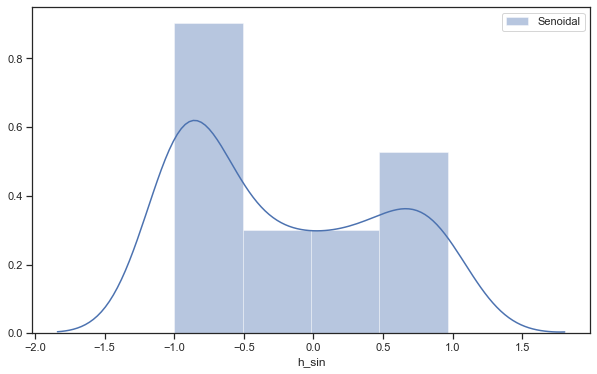

In [6]:
plt.figure(figsize=(10, 6))
sns.distplot(df_sin.h_sin, label='Senoidal')
plt.legend()
plt.show()

In [7]:
y = df_float['Slowness_in_traffic_percent']
X_float = df_float.drop(['Slowness_in_traffic_percent'], axis=1)
X_sin = df_sin.drop(['Slowness_in_traffic_percent'], axis=1)
X_mm = df_mm.drop(['Slowness_in_traffic_percent'], axis=1)
X_nor = df_nor.drop(['Slowness_in_traffic_percent'], axis=1)

In [8]:
from sklearn.model_selection import train_test_split

In [9]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost
from sklearn.model_selection import cross_val_score

sum = 0
for n in range(1000):
    X_f_treino, X_f_teste, y_f_treino, y_f_teste = train_test_split(X_float, y, test_size=0.20)
    modelo_f = xgboost.XGBRegressor(verbosity=0)
    modelo_f.fit(X_f_treino, y_f_treino)
    sum=modelo_f.score(X_f_teste, y_f_teste)+sum
    
print(sum/1000)    

0.565131449806957


In [10]:
sum = 0
for n in range(1000):
    X_s_treino, X_s_teste, y_s_treino, y_s_teste = train_test_split(X_sin, y, test_size=0.20)
    modelo_s = xgboost.XGBRegressor(verbosity=0)
    modelo_s.fit(X_s_treino, y_s_treino)
    modelo_s.score(X_s_teste, y_s_teste)
    sum=modelo_s.score(X_s_teste, y_s_teste)+sum
    
print(sum/1000)

0.4991571166476357


In [11]:
sum = 0
for n in range(1000):
    X_n_treino, X_n_teste, y_n_treino, y_n_teste = train_test_split(X_nor, y, test_size=0.20)
    modelo_n = xgboost.XGBRegressor(verbosity=0)
    modelo_n.fit(X_n_treino, y_n_treino)
    modelo_n.score(X_n_teste, y_n_teste)
    sum=modelo_n.score(X_n_teste, y_n_teste)+sum
    
print(sum/1000)

0.556262083927909


In [12]:
sum = 0
for n in range(1000):
    X_m_treino, X_m_teste, y_m_treino, y_m_teste = train_test_split(X_mm, y, test_size=0.20)
    modelo_m = xgboost.XGBRegressor(verbosity=0)
    modelo_m.fit(X_m_treino, y_m_treino)
    modelo_m.score(X_m_teste, y_m_teste)
    sum=modelo_m.score(X_m_teste, y_m_teste)+sum
    
print(sum/1000)

0.5562196211230909


A forma senoidal foi a pior entre as avaliadas. As outras tiveram perfomance parecida.

In [13]:
df = df_float
df = (df - df.mean())/df.std()
y = df['Slowness_in_traffic_percent']
X = df.drop(['Slowness_in_traffic_percent'], axis=1)

sum = 0
for n in range(1000):
    X_treino, X_teste, y_treino, y_teste = train_test_split(X, y, test_size=0.20)
    modelo_f = xgboost.XGBRegressor(verbosity=0)
    modelo_f.fit(X_treino, y_treino)
    sum=modelo_f.score(X_teste, y_teste)+sum
    
print(sum/1000)   

0.5570126860022326


Padronizar todo o dataframe não trouxe ganhos visíveis.